In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

In [4]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df

In [5]:
# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [6]:
gs_seoul.category.unique()

array(['라면', '과자', '마스크', '맥주', '생리대', '생수', '숙취해소제', '스타킹', '아이스크림',
       '탄산음료', '면도기', '우산'], dtype=object)

In [ ]:
# '마스크'만 빼서 df생성
item = '마스크'
grouped_by='date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']

In [7]:
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# train_data.describe() # 731일
# test_data.describe() # 365일

In [9]:
# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_day_w.iloc[:,3:]
target = gs_day_w.iloc[:,2]

In [10]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [11]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [12]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 35
Number of nun-numerical columns with no nan values : 0


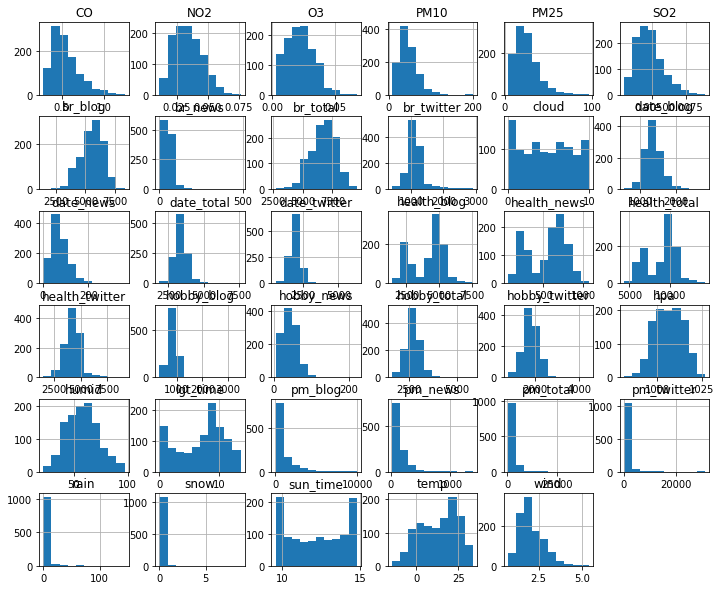

In [13]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

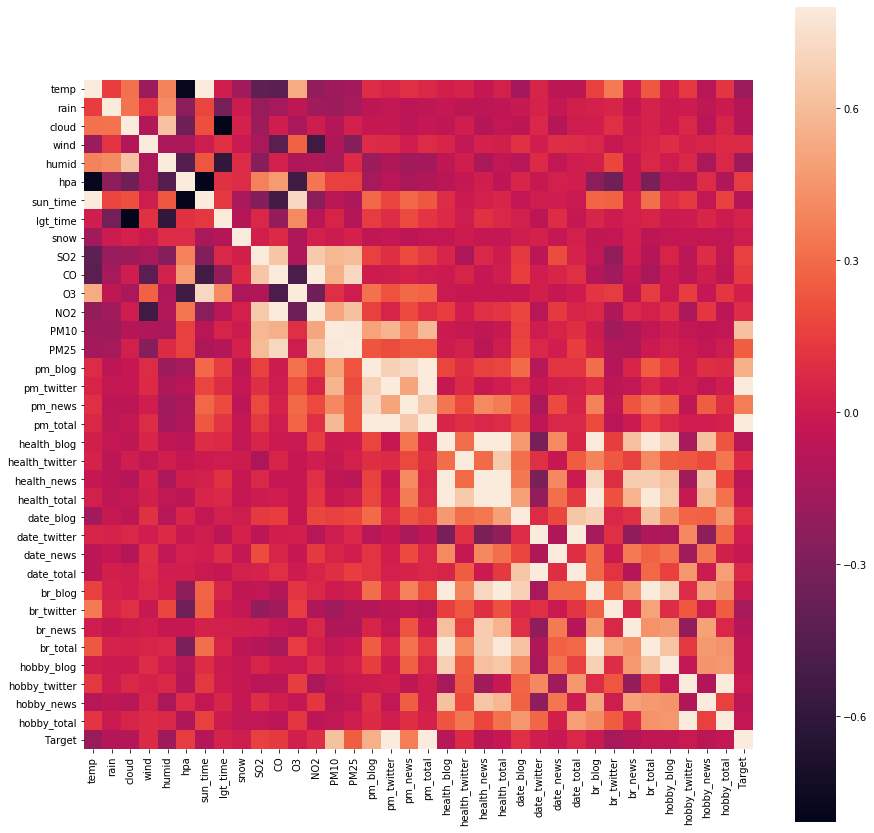

In [14]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [15]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 35 columns before encoding categorical features
There are 35 columns after encoding categorical features


In [16]:
# 이 함수는 경연대회에서 제공된 데이터에 맞춤형이기에, 수치는 내가 필요한 수치로 변경함.
# 2016~2017까지의 날짜수 + 1
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()


In [17]:
train.shape

(732, 35)

In [18]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 10:05:37.182861  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 10:05:37.198819  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 10:05:37.201810  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 10:05:37.258658  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4608      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 169,473
Trainable params: 169,473
Non-trainable params: 0
_________________________________________________________________


In [19]:
checkpoint_name = 'GS-mask-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [20]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 10:06:41.748002  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 10:06:41.853719  2484 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 512us/step - loss: 243.4882 - mean_absolute_error: 243.4882 - val_loss: 208.3784 - val_mean_absolute_error: 208.3784

Epoch 00001: val_loss improved from inf to 208.37843, saving model to GS-mask-Weights-001--208.37843.hdf5
Epoch 2/500
585/585 [==============================] - 0s 77us/step - loss: 185.3037 - mean_absolute_error: 185.3037 - val_loss: 180.8941 - val_mean_absolute_error: 180.8941

Epoch 00002: val_loss improved from 208.37843 to 180.89409, saving model to GS-mask-Weights-002--180.89409.hdf5
Epoch 3/500
585/585 [==============================] - 0s 78us/step - loss: 192.3967 - mean_absolute_error: 192.3967 - val_loss: 166.0636 - val_mean_absolute_error: 166.0636

Epoch 00003: val_loss improved from 180.89409 to 166.06357, saving model to GS-mask-Weights-003--166.06357.hdf5
Epoch 4/500
585/585 [==============================] - 0s 75us/step - loss: 167.6862 - mean_absolu

585/585 [==============================] - 0s 70us/step - loss: 129.0483 - mean_absolute_error: 129.0483 - val_loss: 232.2490 - val_mean_absolute_error: 232.2490

Epoch 00035: val_loss did not improve from 152.65671
Epoch 36/500
585/585 [==============================] - 0s 80us/step - loss: 131.6373 - mean_absolute_error: 131.6373 - val_loss: 164.1509 - val_mean_absolute_error: 164.1509

Epoch 00036: val_loss did not improve from 152.65671
Epoch 37/500
585/585 [==============================] - 0s 77us/step - loss: 133.5491 - mean_absolute_error: 133.5491 - val_loss: 202.5841 - val_mean_absolute_error: 202.5841

Epoch 00037: val_loss did not improve from 152.65671
Epoch 38/500
585/585 [==============================] - 0s 77us/step - loss: 126.9279 - mean_absolute_error: 126.9279 - val_loss: 196.9807 - val_mean_absolute_error: 196.9807

Epoch 00038: val_loss did not improve from 152.65671
Epoch 39/500
585/585 [==============================] - 0s 73us/step - loss: 134.4679 - mean_abso

585/585 [==============================] - 0s 75us/step - loss: 123.0819 - mean_absolute_error: 123.0819 - val_loss: 180.7772 - val_mean_absolute_error: 180.7772

Epoch 00105: val_loss did not improve from 122.35819
Epoch 106/500
585/585 [==============================] - 0s 78us/step - loss: 106.6505 - mean_absolute_error: 106.6505 - val_loss: 178.6260 - val_mean_absolute_error: 178.6260

Epoch 00106: val_loss did not improve from 122.35819
Epoch 107/500
585/585 [==============================] - 0s 75us/step - loss: 109.5653 - mean_absolute_error: 109.5653 - val_loss: 148.1791 - val_mean_absolute_error: 148.1791

Epoch 00107: val_loss did not improve from 122.35819
Epoch 108/500
585/585 [==============================] - 0s 77us/step - loss: 103.5184 - mean_absolute_error: 103.5184 - val_loss: 150.5217 - val_mean_absolute_error: 150.5217

Epoch 00108: val_loss did not improve from 122.35819
Epoch 109/500
585/585 [==============================] - 0s 72us/step - loss: 113.3231 - mean_


Epoch 00175: val_loss did not improve from 120.21791
Epoch 176/500
585/585 [==============================] - 0s 73us/step - loss: 105.7136 - mean_absolute_error: 105.7136 - val_loss: 169.7401 - val_mean_absolute_error: 169.7401

Epoch 00176: val_loss did not improve from 120.21791
Epoch 177/500
585/585 [==============================] - 0s 75us/step - loss: 107.8382 - mean_absolute_error: 107.8382 - val_loss: 156.0772 - val_mean_absolute_error: 156.0772

Epoch 00177: val_loss did not improve from 120.21791
Epoch 178/500
585/585 [==============================] - 0s 77us/step - loss: 101.1414 - mean_absolute_error: 101.1414 - val_loss: 150.7548 - val_mean_absolute_error: 150.7548

Epoch 00178: val_loss did not improve from 120.21791
Epoch 179/500
585/585 [==============================] - 0s 73us/step - loss: 98.1996 - mean_absolute_error: 98.1996 - val_loss: 189.8954 - val_mean_absolute_error: 189.8954

Epoch 00179: val_loss did not improve from 120.21791
Epoch 180/500
585/585 [=====


Epoch 00211: val_loss did not improve from 120.21791
Epoch 212/500
585/585 [==============================] - 0s 78us/step - loss: 86.6434 - mean_absolute_error: 86.6434 - val_loss: 179.3049 - val_mean_absolute_error: 179.3049

Epoch 00212: val_loss did not improve from 120.21791
Epoch 213/500
585/585 [==============================] - 0s 75us/step - loss: 93.1125 - mean_absolute_error: 93.1125 - val_loss: 227.6799 - val_mean_absolute_error: 227.6799

Epoch 00213: val_loss did not improve from 120.21791
Epoch 214/500
585/585 [==============================] - 0s 75us/step - loss: 115.2892 - mean_absolute_error: 115.2892 - val_loss: 169.2626 - val_mean_absolute_error: 169.2626

Epoch 00214: val_loss did not improve from 120.21791
Epoch 215/500
585/585 [==============================] - 0s 75us/step - loss: 91.1600 - mean_absolute_error: 91.1600 - val_loss: 187.8199 - val_mean_absolute_error: 187.8199

Epoch 00215: val_loss did not improve from 120.21791
Epoch 216/500
585/585 [=========


Epoch 00247: val_loss did not improve from 120.21791
Epoch 248/500
585/585 [==============================] - 0s 73us/step - loss: 87.4435 - mean_absolute_error: 87.4435 - val_loss: 139.3666 - val_mean_absolute_error: 139.3666

Epoch 00248: val_loss did not improve from 120.21791
Epoch 249/500
585/585 [==============================] - 0s 77us/step - loss: 89.7968 - mean_absolute_error: 89.7968 - val_loss: 130.2509 - val_mean_absolute_error: 130.2509

Epoch 00249: val_loss did not improve from 120.21791
Epoch 250/500
585/585 [==============================] - 0s 73us/step - loss: 84.3387 - mean_absolute_error: 84.3387 - val_loss: 169.6503 - val_mean_absolute_error: 169.6503

Epoch 00250: val_loss did not improve from 120.21791
Epoch 251/500
585/585 [==============================] - 0s 77us/step - loss: 88.6022 - mean_absolute_error: 88.6022 - val_loss: 144.4524 - val_mean_absolute_error: 144.4524

Epoch 00251: val_loss did not improve from 120.21791
Epoch 252/500
585/585 [===========


Epoch 00283: val_loss did not improve from 120.21791
Epoch 284/500
585/585 [==============================] - 0s 73us/step - loss: 78.1032 - mean_absolute_error: 78.1032 - val_loss: 181.5789 - val_mean_absolute_error: 181.5789

Epoch 00284: val_loss did not improve from 120.21791
Epoch 285/500
585/585 [==============================] - 0s 75us/step - loss: 81.6154 - mean_absolute_error: 81.6154 - val_loss: 158.0698 - val_mean_absolute_error: 158.0698

Epoch 00285: val_loss did not improve from 120.21791
Epoch 286/500
585/585 [==============================] - 0s 77us/step - loss: 84.6609 - mean_absolute_error: 84.6609 - val_loss: 149.9093 - val_mean_absolute_error: 149.9093

Epoch 00286: val_loss did not improve from 120.21791
Epoch 287/500
585/585 [==============================] - 0s 75us/step - loss: 77.1544 - mean_absolute_error: 77.1544 - val_loss: 127.1353 - val_mean_absolute_error: 127.1353

Epoch 00287: val_loss did not improve from 120.21791
Epoch 288/500
585/585 [===========


Epoch 00319: val_loss did not improve from 120.21791
Epoch 320/500
585/585 [==============================] - 0s 87us/step - loss: 72.2868 - mean_absolute_error: 72.2868 - val_loss: 168.3721 - val_mean_absolute_error: 168.3721

Epoch 00320: val_loss did not improve from 120.21791
Epoch 321/500
585/585 [==============================] - 0s 83us/step - loss: 75.4912 - mean_absolute_error: 75.4912 - val_loss: 161.4342 - val_mean_absolute_error: 161.4342

Epoch 00321: val_loss did not improve from 120.21791
Epoch 322/500
585/585 [==============================] - 0s 75us/step - loss: 77.7883 - mean_absolute_error: 77.7883 - val_loss: 148.9870 - val_mean_absolute_error: 148.9870

Epoch 00322: val_loss did not improve from 120.21791
Epoch 323/500
585/585 [==============================] - 0s 81us/step - loss: 77.1764 - mean_absolute_error: 77.1764 - val_loss: 153.0303 - val_mean_absolute_error: 153.0303

Epoch 00323: val_loss did not improve from 120.21791
Epoch 324/500
585/585 [===========


Epoch 00355: val_loss did not improve from 120.21791
Epoch 356/500
585/585 [==============================] - 0s 90us/step - loss: 79.8541 - mean_absolute_error: 79.8541 - val_loss: 173.9820 - val_mean_absolute_error: 173.9820

Epoch 00356: val_loss did not improve from 120.21791
Epoch 357/500
585/585 [==============================] - 0s 86us/step - loss: 82.7727 - mean_absolute_error: 82.7727 - val_loss: 152.5564 - val_mean_absolute_error: 152.5564

Epoch 00357: val_loss did not improve from 120.21791
Epoch 358/500
585/585 [==============================] - 0s 82us/step - loss: 79.4105 - mean_absolute_error: 79.4105 - val_loss: 161.6008 - val_mean_absolute_error: 161.6008

Epoch 00358: val_loss did not improve from 120.21791
Epoch 359/500
585/585 [==============================] - 0s 79us/step - loss: 86.2086 - mean_absolute_error: 86.2086 - val_loss: 167.5265 - val_mean_absolute_error: 167.5265

Epoch 00359: val_loss did not improve from 120.21791
Epoch 360/500
585/585 [===========


Epoch 00426: val_loss did not improve from 114.96073
Epoch 427/500
585/585 [==============================] - 0s 102us/step - loss: 68.3722 - mean_absolute_error: 68.3722 - val_loss: 168.2972 - val_mean_absolute_error: 168.2972

Epoch 00427: val_loss did not improve from 114.96073
Epoch 428/500
585/585 [==============================] - 0s 95us/step - loss: 66.7714 - mean_absolute_error: 66.7714 - val_loss: 161.8968 - val_mean_absolute_error: 161.8968

Epoch 00428: val_loss did not improve from 114.96073
Epoch 429/500
585/585 [==============================] - 0s 92us/step - loss: 68.3360 - mean_absolute_error: 68.3360 - val_loss: 151.3831 - val_mean_absolute_error: 151.3831

Epoch 00429: val_loss did not improve from 114.96073
Epoch 430/500
585/585 [==============================] - 0s 107us/step - loss: 64.6828 - mean_absolute_error: 64.6828 - val_loss: 153.0889 - val_mean_absolute_error: 153.0889

Epoch 00430: val_loss did not improve from 114.96073
Epoch 431/500
585/585 [=========


Epoch 00462: val_loss did not improve from 114.96073
Epoch 463/500
585/585 [==============================] - 0s 97us/step - loss: 55.8655 - mean_absolute_error: 55.8655 - val_loss: 179.5029 - val_mean_absolute_error: 179.5029

Epoch 00463: val_loss did not improve from 114.96073
Epoch 464/500
585/585 [==============================] - 0s 122us/step - loss: 60.6096 - mean_absolute_error: 60.6096 - val_loss: 171.1398 - val_mean_absolute_error: 171.1398

Epoch 00464: val_loss did not improve from 114.96073
Epoch 465/500
585/585 [==============================] - 0s 101us/step - loss: 53.3121 - mean_absolute_error: 53.3121 - val_loss: 163.7244 - val_mean_absolute_error: 163.7244

Epoch 00465: val_loss did not improve from 114.96073
Epoch 466/500
585/585 [==============================] - 0s 95us/step - loss: 57.4187 - mean_absolute_error: 57.4187 - val_loss: 164.1662 - val_mean_absolute_error: 164.1662

Epoch 00466: val_loss did not improve from 114.96073
Epoch 467/500
585/585 [=========


Epoch 00498: val_loss did not improve from 114.96073
Epoch 499/500
585/585 [==============================] - 0s 116us/step - loss: 50.0974 - mean_absolute_error: 50.0974 - val_loss: 164.4243 - val_mean_absolute_error: 164.4243

Epoch 00499: val_loss did not improve from 114.96073
Epoch 500/500
585/585 [==============================] - 0s 102us/step - loss: 57.0977 - mean_absolute_error: 57.0977 - val_loss: 144.6092 - val_mean_absolute_error: 144.6092

Epoch 00500: val_loss did not improve from 114.96073


In [22]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
wights_file = 'GS-mask-Weights-414--114.96073.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [23]:
# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(test)

In [24]:
# rf나,XGB회귀 분석을위한 훈련/검증 dataset생산
train_X, val_X, train_y, val_y = train_test_split(train, target[:732], test_size = 0.25, random_state = 14)

In [25]:
# RandomForest 회귀분석
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  120.60601092896175


In [26]:
# XGBRegressor 회귀분석
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[10:10:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  112.92455395974748


In [36]:
combined = gs_day_w.iloc[:,3:38]
target = gs_day_w.iloc[:,2]
predicted_prices = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = gs_day_w.iloc[:,2]
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",predicted_prices.shape)
result_df['rf_qty'] = predicted_prices
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1096, 1)
randomforest 예상 (1096,)
XGBpredictions (1096,)


In [38]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

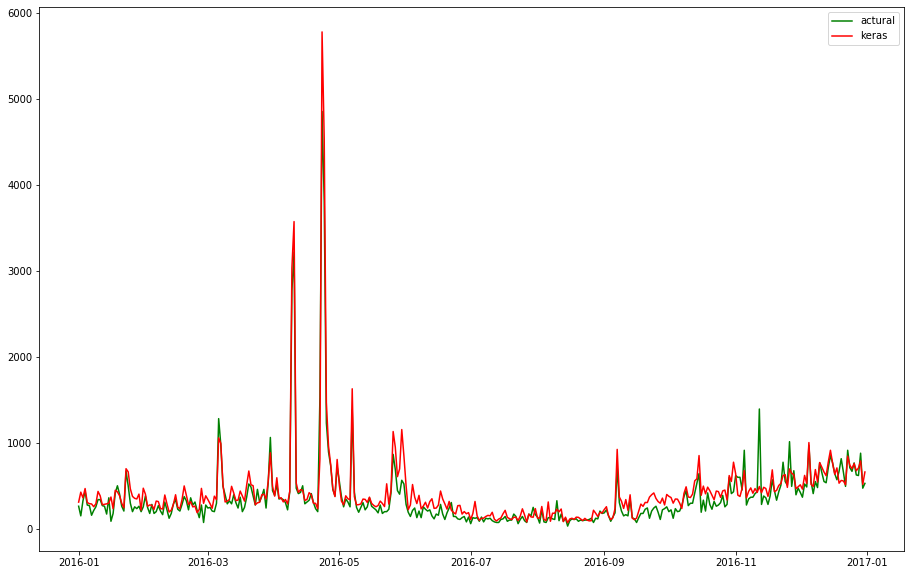

In [39]:
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

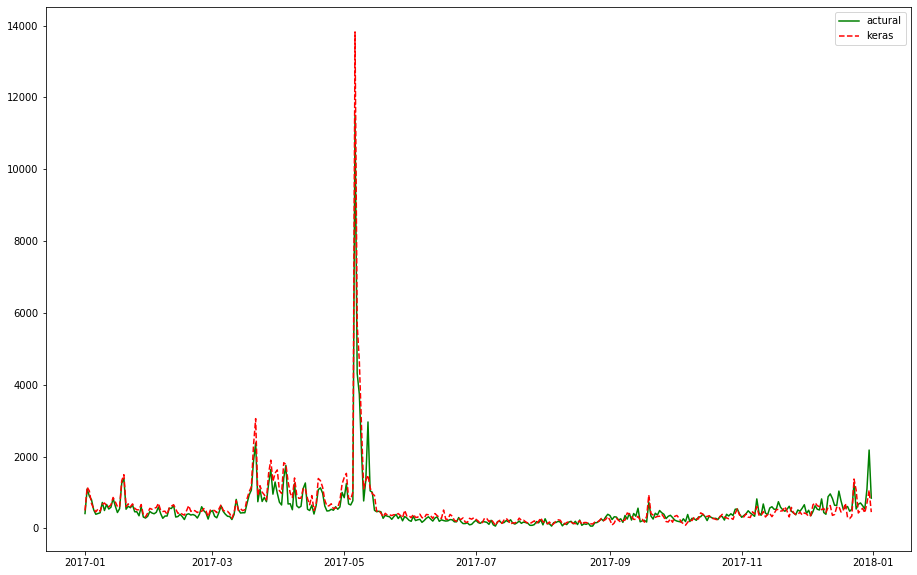

In [40]:
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='--', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

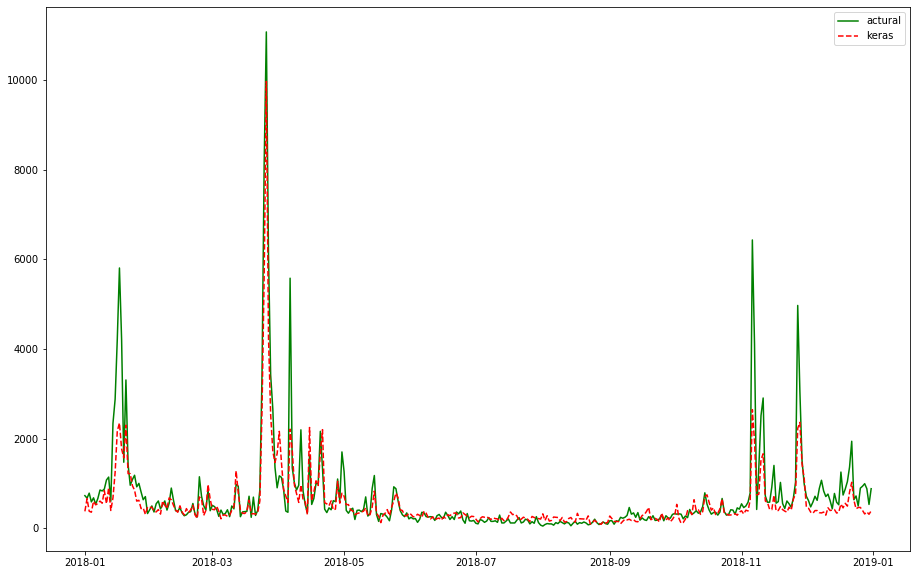

In [42]:
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green')
plt.plot(df_graph.date,df_graph.keras_qty, ls='--', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

In [44]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)